In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
DATASET_PATH="/data/RadVel"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_azmith_resp import RangeAzimuthProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.plotting.movies_mmWave_data import MovieGeneratorMmWaveData

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ModuleNotFoundError: No module named 'mmwave_radar_processing.processors.range_azmith_resp'

In [ ]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz.cfg")
cfg_manager.load_cfg(cfg_path,
                     array_geometry="ods",
                     array_direction="down")
cfg_manager.compute_radar_perforance(profile_idx=0)

dataset_name = "CPSL_RadVel_10Hz_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

/data/RadVel/CPSL_RadVel_20Hz_1
found 160 radar samples
did not find lidar samples
found 160 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 160 vehicle velocity samples
found 160 vehicle odometry samples


In [ ]:
#load the plotter
plotter = PlotterMmWaveData(config_manager=cfg_manager)

#initialize a range azimuth processor
range_az_processor = RangeAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

#initialize the range doppler processor
range_doppler_processor = RangeDopplerProcessor(
    config_manager=cfg_manager
)

doppler_azimuth_processor = DopplerAzimuthProcessor(
    config_manager=cfg_manager,
    num_angle_bins=64
)

micro_doppler_processor = MicroDopplerProcessor(
    config_manager=cfg_manager,
    target_ranges=np.array([3.0,3.7]),
    num_frames_history=20
)

#load the ADC data reformatter
virtual_array_reformatter = VirtualArrayReformatter(config_manager=cfg_manager)

#initialize the movie generator
movie_generator = MovieGeneratorMmWaveData(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_azimuth_processor=range_az_processor,
    range_doppler_processor=range_doppler_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=micro_doppler_processor,
    virtual_array_reformatter=virtual_array_reformatter,
    temp_dir_path=os.path.join("~/Downloads/RadVel",dataset_name)
)

found temp dir: /home/david/Downloads/RadVel/CPSL_RadVel_20Hz_1
clearing temp directory /home/david/Downloads/RadVel/CPSL_RadVel_20Hz_1


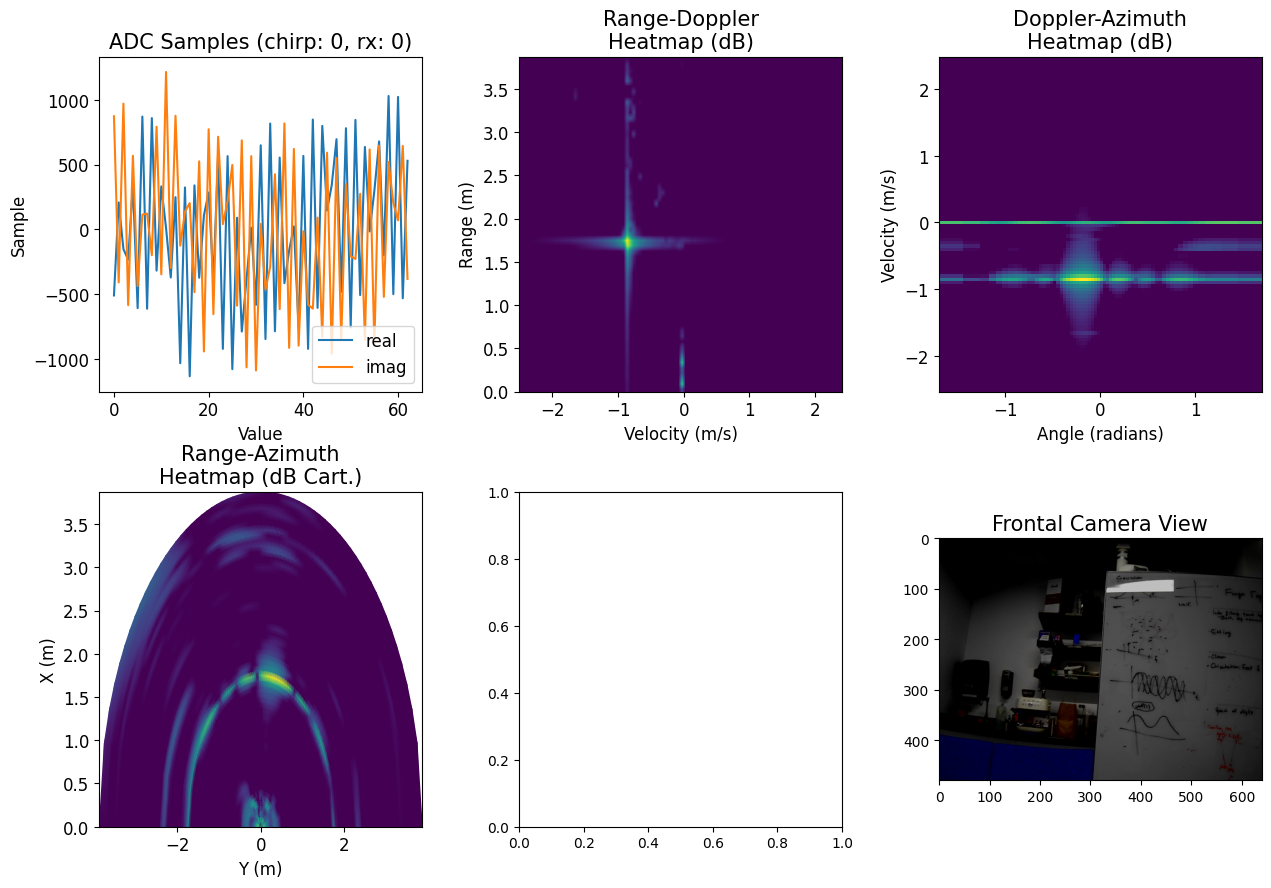

In [ ]:
#for getting access to the adc cube
idx=20
#compute responses over a series of frames
for i in range(micro_doppler_processor.num_frames_history):

    #get the ADC cube
    adc_cube = dataset.get_radar_data(idx + i)

    adc_cube = virtual_array_reformatter.process(adc_cube)
    rng_az_resp = range_az_processor.process(adc_cube=adc_cube,chirp_idx=0)
    rng_dop_resp = range_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)
    dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)
    # micro_doppler_resp = micro_doppler_processor.process(adc_cube=adc_cube,rx_idx=0)

    try:
        camera_view = dataset.get_camera_frame(idx + i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

#for generating a compilation of plots
fig,axs=plt.subplots(2,3, figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=0.30)

plotter.plot_compilation(
    adc_cube=adc_cube,
    range_doppler_processor=range_doppler_processor,
    range_azimuth_processor=range_az_processor,
    doppler_azimuth_processor=doppler_azimuth_processor,
    micro_doppler_processor=None,
    camera_view=camera_view,
    convert_to_dB=True,
    cmap="viridis",
    chirp_idx=0,
    rx_antenna_idx=0,
    axs=axs,
    show=True
)

(100, 64)


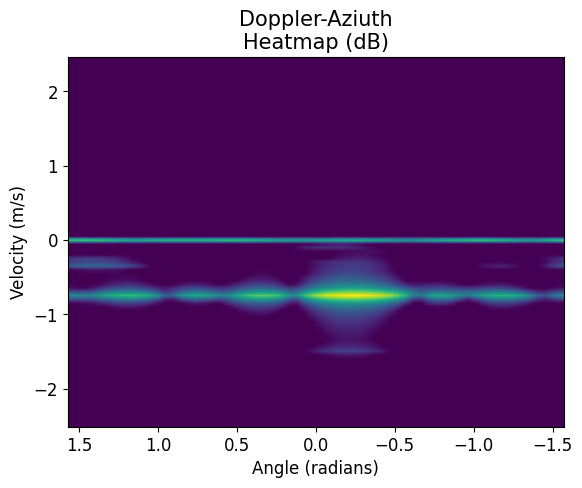

In [ ]:
#compute doppler-azimuth response:

idx=40#319
adc_cube = dataset.get_radar_data(idx)
adc_cube = virtual_array_reformatter.process(adc_cube)
dop_az_resp = doppler_azimuth_processor.process(adc_cube=adc_cube)

#convert to dB
dop_az_resp_dB = np.log10(np.abs(dop_az_resp))

print(dop_az_resp.shape)

fig,ax = plt.subplots()
plotter.plot_doppler_az_resp_old(
    dop_az_resp,
    doppler_azimuth_processor,
    convert_to_dB=True,
    ax=ax,
    show=True
)

alpha: 2.3168965022772032 (mag), 7.298132678442336 dB
(130, 2)
(130, 4)
[-5.87151429e-04 -1.06009909e+00]


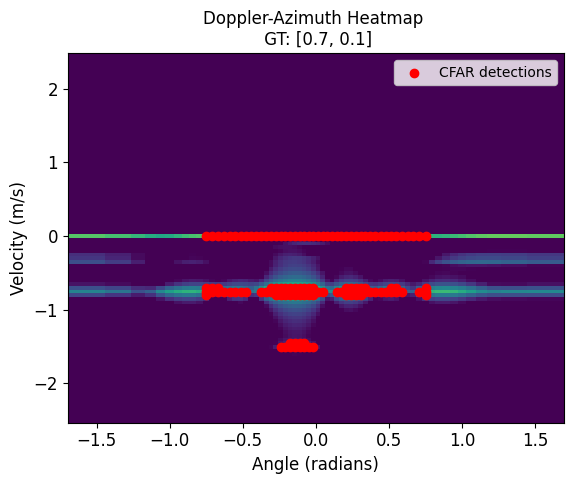

In [ ]:
#initialize a CFAR detector
from mmwave_radar_processing.detectors.CFAR import CaCFAR_2D
from mmwave_radar_processing.point_cloud_processing.vehicle_vel_estimator import VehicleVelEstimator

vel_estimator = VehicleVelEstimator(
    points_per_fit=65,
    max_iters=100,
    fit_thresh=0.05,
    num_close_pts=67,
    static_vel_thresh=0.2
)

odom_data = dataset.get_vehicle_odom_data(idx=idx)
gt_vel = np.mean(odom_data[:,8:10],axis=0)

cfar_detector = CaCFAR_2D(
    num_guard_cells=np.array([2,3]),
    num_training_cells=np.array([4,5]),
    false_alarm_rate=0.1,
    resp_border_cells=np.array([2,2]),
    mode="valid"
)

# Run CFAR detector
det_idxs, T = cfar_detector.compute(dop_az_resp)

# Get detection indices
vel_inds, angle_inds = np.where(det_idxs == 1)

# Map to physical bin values
det_vels = doppler_azimuth_processor.vel_bins[vel_inds]
det_angles = doppler_azimuth_processor.angle_bins[angle_inds]

# Filter out velocities near zero
velocity_threshold = 0.05  # adjust this as needed
valid_mask = np.abs(det_vels) >= velocity_threshold

# Apply the mask
# filtered_vels = det_vels[valid_mask]
# filtered_angles = det_angles[valid_mask]

filtered_vels = det_vels
filtered_angles = det_angles

# Stack into (N, 2) array
detection_coordinates = np.stack((filtered_vels, filtered_angles), axis=1)

print(detection_coordinates.shape)

#estimate the velocity
vel_est_dets = np.zeros((detection_coordinates.shape[0],4))
vel_est_dets[:,3] = detection_coordinates[:,1]
vel_est_dets[:,0] = np.cos(detection_coordinates[:,1])
vel_est_dets[:,1] = np.sin(detection_coordinates[:,1])
print(vel_est_dets.shape)

est_vel = vel_estimator.estimate_ego_vel(
    detections=vel_est_dets,
    initial_ego_vel_est=np.empty(shape=0),
    only_2D=True
)
print(est_vel)


fig,ax = plt.subplots()
plotter.plot_doppler_az_resp(
    dop_az_resp,
    doppler_azimuth_processor,
    convert_to_dB=True,
    ax=ax,
    show=False
)
ax.scatter(x=detection_coordinates[:,1],y=detection_coordinates[:,0],color="red",label="CFAR detections")
formatted_gt_vel = np.array2string(gt_vel, precision=2, separator=', ')
ax.set_title(f"Doppler-Azimuth Heatmap \n GT: {formatted_gt_vel}")
plt.legend()
plt.show()

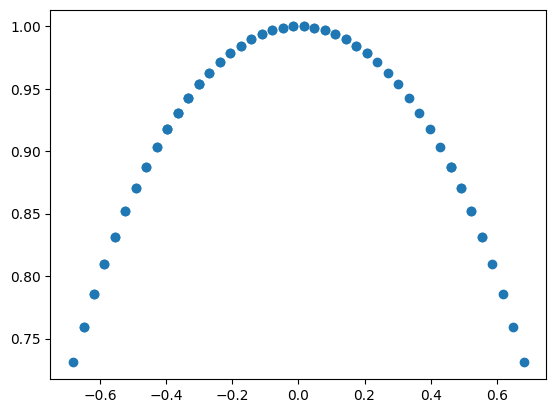

In [ ]:
plt.scatter(x=vel_est_dets[:,1],y=vel_est_dets[:,0])

[-1.90853360e+00 -1.78129803e+00 -1.65406245e+00 -1.52682688e+00
 -1.39959131e+00 -1.27235573e+00 -1.14512016e+00 -1.01788459e+00
 -8.90649014e-01 -7.63413440e-01 -6.36177867e-01 -5.08942294e-01
 -3.81706720e-01 -2.54471147e-01 -1.27235573e-01 -1.11022302e-15
  1.27235573e-01  2.54471147e-01  3.81706720e-01  5.08942294e-01
  6.36177867e-01  7.63413440e-01  8.90649014e-01  1.01788459e+00
  1.14512016e+00  1.27235573e+00  1.39959131e+00  1.52682688e+00
  1.65406245e+00  1.78129803e+00]


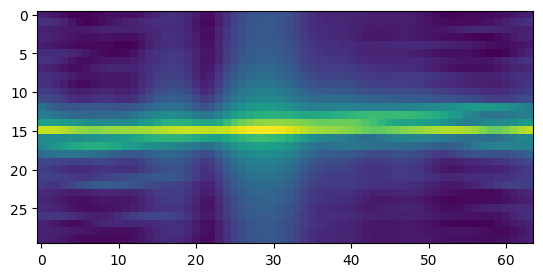

In [ ]:
plt.imshow(dop_az_resp_dB)
print(doppler_azimuth_processor.vel_bins)



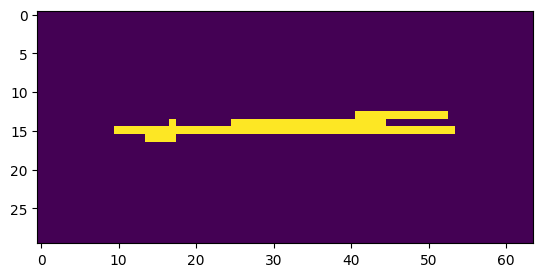

In [ ]:
plt.imshow(det_idxs)
